This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

Metal device set to: Apple M1
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


2022-04-30 19:29:34.800746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-30 19:29:34.801033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [3]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[ 1.1437572]
 [-1.1868219]
 [ 1.2598592]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.55641615]
 [0.94725955]
 [0.18071926]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

**Creating a TensorFlow variable**

In [6]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.41358915],
       [-0.40850848],
       [-0.20871626]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [7]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [17]:
#with tf.device('/CPU:0'):
# v[0, 0].assign(3.)
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [18]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[2.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [22]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [24]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


**Using `GradientTape` with constant tensor inputs**

In [25]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


**Using nested gradient tapes to compute second-order gradients**

In [26]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
print(speed)
print(acceleration)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [27]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [28]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [29]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

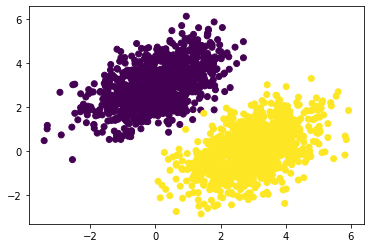

In [30]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [31]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [32]:
print(inputs.shape)
def model(inputs):
    return tf.matmul(inputs, W) + b

(2000, 2)


**The mean squared error loss function**

In [33]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [34]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [35]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.5045
Loss at step 1: 0.2932
Loss at step 2: 0.1346
Loss at step 3: 0.1065
Loss at step 4: 0.0970
Loss at step 5: 0.0904
Loss at step 6: 0.0847
Loss at step 7: 0.0795
Loss at step 8: 0.0748
Loss at step 9: 0.0705
Loss at step 10: 0.0666
Loss at step 11: 0.0630
Loss at step 12: 0.0597
Loss at step 13: 0.0567
Loss at step 14: 0.0539
Loss at step 15: 0.0514
Loss at step 16: 0.0491
Loss at step 17: 0.0470
Loss at step 18: 0.0450
Loss at step 19: 0.0433
Loss at step 20: 0.0417
Loss at step 21: 0.0402
Loss at step 22: 0.0389
Loss at step 23: 0.0376
Loss at step 24: 0.0365
Loss at step 25: 0.0355
Loss at step 26: 0.0345
Loss at step 27: 0.0337
Loss at step 28: 0.0329
Loss at step 29: 0.0322
Loss at step 30: 0.0315
Loss at step 31: 0.0309
Loss at step 32: 0.0304
Loss at step 33: 0.0299
Loss at step 34: 0.0294
Loss at step 35: 0.0290
Loss at step 36: 0.0286
Loss at step 37: 0.0283
Loss at step 38: 0.0279
Loss at step 39: 0.0276


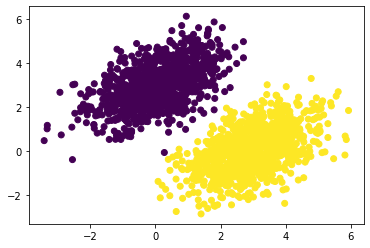

In [36]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

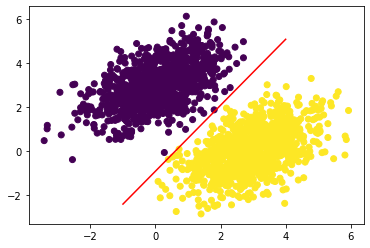

In [37]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [38]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [39]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [40]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [42]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [43]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [44]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [47]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 5ms/step - loss: 1.9577 - binary_accuracy: 0.9720
Epoch 2/5
16/16 [==============================] - 0s 4ms/step - loss: 1.8228 - binary_accuracy: 0.9705
Epoch 3/5
16/16 [==============================] - 0s 6ms/step - loss: 1.6940 - binary_accuracy: 0.9705
Epoch 4/5
16/16 [==============================] - 0s 4ms/step - loss: 1.5705 - binary_accuracy: 0.9695
Epoch 5/5
16/16 [==============================] - 0s 5ms/step - loss: 1.4519 - binary_accuracy: 0.9690


In [48]:
history.history

{'loss': [1.9576741456985474,
  1.822791576385498,
  1.6940205097198486,
  1.570467472076416,
  1.4518862962722778],
 'binary_accuracy': [0.9720000624656677,
  0.9705000519752502,
  0.9705000519752502,
  0.9695000648498535,
  0.9690000414848328]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [49]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
23/88 [======>.......................] - ETA: 0s - loss: 0.2274 - binary_accuracy: 0.9946

2022-04-30 22:41:15.065805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 6ms/step - loss: 0.1122 - binary_accuracy: 0.9700 - val_loss: 0.2332 - val_binary_accuracy: 0.7700
Epoch 2/5
14/88 [===>..........................] - ETA: 0s - loss: 0.0600 - binary_accuracy: 0.9598

2022-04-30 22:41:15.567733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 0s 5ms/step - loss: 0.0661 - binary_accuracy: 0.9614 - val_loss: 0.2711 - val_binary_accuracy: 0.7400
Epoch 3/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0752 - binary_accuracy: 0.9614 - val_loss: 0.0288 - val_binary_accuracy: 0.9983
Epoch 4/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0698 - binary_accuracy: 0.9479 - val_loss: 0.0766 - val_binary_accuracy: 0.9850
Epoch 5/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0726 - binary_accuracy: 0.9536 - val_loss: 0.1522 - val_binary_accuracy: 0.7933


### Inference: Using a model after training

In [50]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[0.46303374]
 [1.0530683 ]
 [0.30181813]
 [0.53011465]
 [0.33173543]
 [0.6730426 ]
 [1.0040338 ]
 [0.37964967]
 [0.7316977 ]
 [1.3563633 ]]


2022-04-30 22:51:41.318858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Summary